# SVHN Autoencoder - Unsupervised Image Reconstruction

## This notebook implements a convolutional autoencoder for the Street View House Numbers (SVHN) dataset.
## The goal is to learn a compressed latent representation and reconstruct images without using labels.

## 1. Setup and Imports

In [ ]:
# %% Cell 1: Import libraries and set random seeds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import scipy.io
import os
import kagglehub

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Dataset Loading and Preprocessing

In [ ]:
path = kagglehub.dataset_download("stanfordu/street-view-house-numbers")
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2


In [ ]:
# %% Cell 3: Load training data from PNG images
from PIL import Image

def load_svhn_images_from_folder(folder_path, max_images=10000):
    """Load PNG images from folder"""
    images = []
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')][:max_images]

    print(f"Loading {len(image_files)} images from {folder_path}...")

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        # Resize to 32x32 if needed
        if img.size != (32, 32):
            img = img.resize((32, 32))
        img_array = np.array(img)
        # Ensure RGB (some might be grayscale)
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array] * 3, axis=-1)
        elif img_array.shape[2] == 4:  # RGBA
            img_array = img_array[:, :, :3]
        images.append(img_array)

    images = np.array(images, dtype='float32') / 255.0

    print(f"Loaded images shape: {images.shape}")
    print(f"Data type: {images.dtype}")
    print(f"Value range: [{images.min():.3f}, {images.max():.3f}]")

    return images

# Load training images
train_folder = os.path.join(path, 'train', 'train')
X_train = load_svhn_images_from_folder(train_folder, max_images=20000)  # Adjust max_images as needed

Loading 20000 images from /root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2/train/train...
Loaded images shape: (20000, 32, 32, 3)
Data type: float32
Value range: [0.000, 1.000]


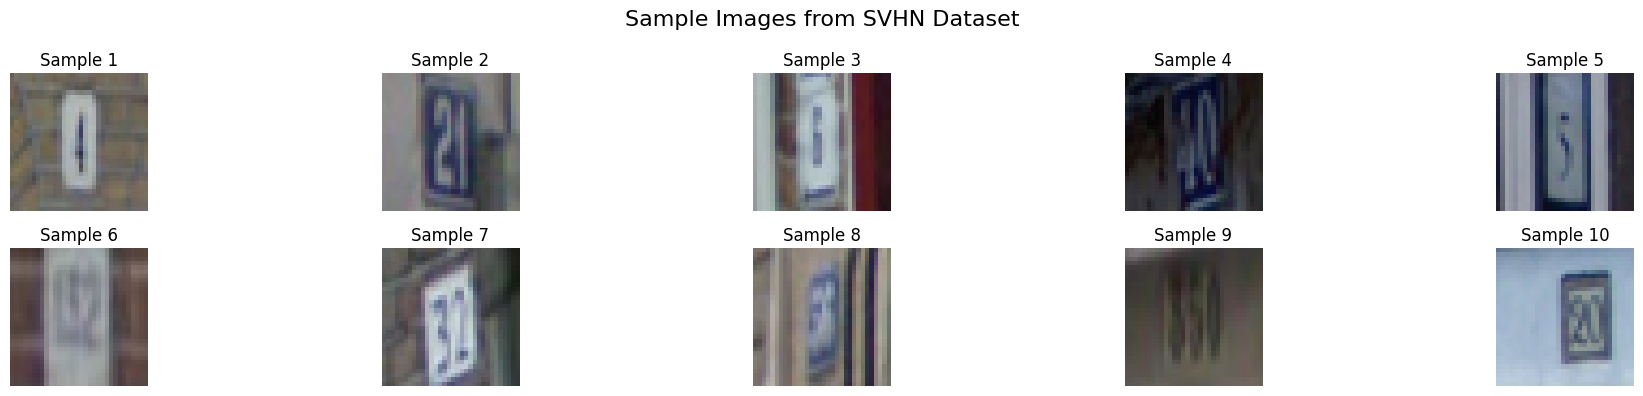

In [ ]:
# %% Cell 4: Visualize sample images
def plot_sample_images(images, n_samples=10):
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f'Sample {i+1}')
    plt.suptitle('Sample Images from SVHN Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train[:10])


## 3. Model Architecture

### An autoencoder learns to compress data into a lower-dimensional representation (latent space)
### and reconstruct the original data. It consists of an encoder (compression) and decoder (reconstruction).


In [ ]:
# %% Cell 5: Build autoencoder architecture
def build_autoencoder(latent_dim=64, input_shape=(32, 32, 3)):
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='input_image')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)
    encoder = models.Model(encoder_input, latent, name='encoder')

    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,), name='latent_input')
    x = layers.Dense(4 * 4 * 128, activation='relu')(decoder_input)
    x = layers.Reshape((4, 4, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same',
                                   name='output_image')(x)
    decoder = models.Model(decoder_input, decoder_output, name='decoder')

    # Complete autoencoder
    autoencoder_output = decoder(encoder(encoder_input))
    autoencoder = models.Model(encoder_input, autoencoder_output, name='autoencoder')

    return autoencoder, encoder, decoder


In [ ]:
# %% Cell 6: Build model and display architecture
latent_dim_default = 64
autoencoder, encoder, decoder = build_autoencoder(latent_dim=latent_dim_default)

print("=" * 70)
print("ENCODER ARCHITECTURE")
print("=" * 70)
encoder.summary()

print("\n" + "=" * 70)
print("DECODER ARCHITECTURE")
print("=" * 70)
decoder.summary()

print("\n" + "=" * 70)
print("COMPLETE AUTOENCODER ARCHITECTURE")
print("=" * 70)
autoencoder.summary()

ENCODER ARCHITECTURE


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │       131,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,384 (876.50 KB)

 Trainable params: 224,384 (876.50 KB)

 Non-trainable params: 0 (0.00 B)


DECODER ARCHITECTURE


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,827 (1.43 MB)

 Trainable params: 373,827 (1.43 MB)

 Non-trainable params: 0 (0.00 B)


COMPLETE AUTOENCODER ARCHITECTURE


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       224,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       373,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,211 (2.28 MB)

 Trainable params: 598,211 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Compilation and Training

In [ ]:
# %% Cell 7: Compile the model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
print("Model compiled with MSE loss and Adam optimizer")

Model compiled with MSE loss and Adam optimizer


In [ ]:
# %% Cell 8: Set training configuration
EPOCHS = 20
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1

print(f"Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Validation Split: {VALIDATION_SPLIT}")

Training Configuration:
  Epochs: 20
  Batch Size: 128
  Validation Split: 0.1


In [ ]:
# %% Cell 9: Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    shuffle=True,
    verbose=1
)


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms

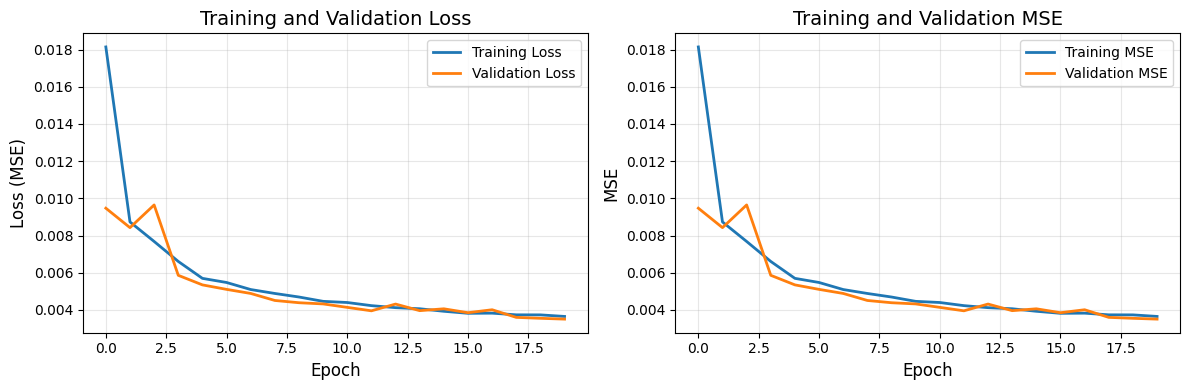

In [ ]:
# %% Cell 10: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label='Training MSE', linewidth=2)
    plt.plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.title('Training and Validation MSE', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)




## 5. Experiment 1: Reconstruction Results


In [ ]:
# %% Cell 11: Generate reconstructions
n_samples = 10
sample_indices = np.random.choice(len(X_train), n_samples, replace=False)
sample_images = X_train[sample_indices]
reconstructed_images = autoencoder.predict(sample_images, verbose=0)

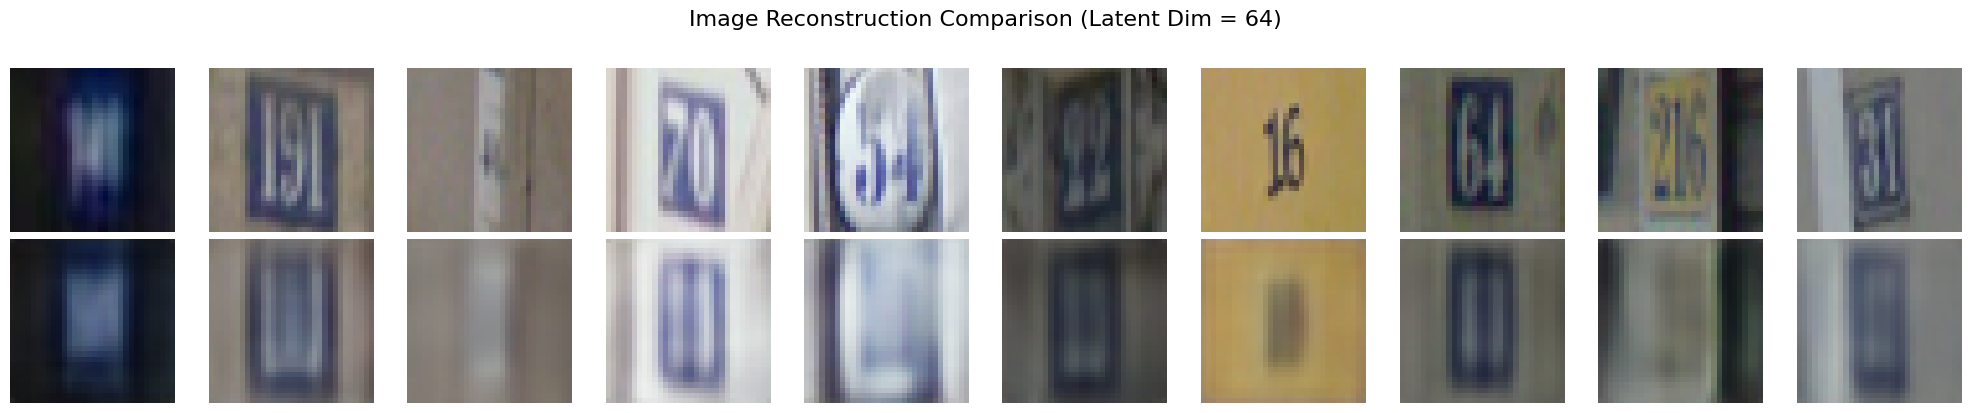

In [ ]:
# %% Cell 12: Display original vs reconstructed images
def plot_reconstruction_comparison(original, reconstructed, n_samples=10):
    plt.figure(figsize=(20, 4))

    for i in range(n_samples):
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(original[i])
        plt.axis('off')
        if i == 0:
            plt.ylabel('Original', fontsize=12, rotation=0, labelpad=40)

        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.ylabel('Reconstructed', fontsize=12, rotation=0, labelpad=40)

    plt.suptitle(f'Image Reconstruction Comparison (Latent Dim = {latent_dim_default})',
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_reconstruction_comparison(sample_images, reconstructed_images, n_samples)


In [ ]:
# %% Cell 13: Calculate reconstruction error
mse_per_image = np.mean((sample_images - reconstructed_images) ** 2, axis=(1, 2, 3))
avg_mse = np.mean(mse_per_image)

print(f"Reconstruction Quality Metrics:")
print(f"  Average MSE: {avg_mse:.6f}")
print(f"  MSE range: [{mse_per_image.min():.6f}, {mse_per_image.max():.6f}]")


Reconstruction Quality Metrics:
  Average MSE: 0.003217
  MSE range: [0.001079, 0.011153]


## 6. Experiment 2: Latent Representation Analysis

### A **latent representation** is a compressed encoding that captures essential features of the input.
### It reduces dimensionality (32×32×3 = 3,072 dims → latent_dim dims) while preserving enough
### information for reconstruction.

In [ ]:
# %% Cell 14: Extract latent representations
sample_latent_vectors = encoder.predict(sample_images, verbose=0)

print(f"Latent Representation Analysis:")
print(f"  Original dimensions: {np.prod(sample_images[0].shape)} values")
print(f"  Latent dimensions: {sample_latent_vectors[0].shape[0]} values")
print(f"  Compression ratio: {np.prod(sample_images[0].shape) / sample_latent_vectors[0].shape[0]:.1f}x")


Latent Representation Analysis:
  Original dimensions: 3072 values
  Latent dimensions: 64 values
  Compression ratio: 48.0x


In [ ]:
# %% Cell 15: Display example latent vector
print("EXAMPLE LATENT VECTOR")
print(f"Shape: {sample_latent_vectors[0].shape}")
print(f"First 20 values: {sample_latent_vectors[0][:20]}")
print(f"Statistics - Mean: {sample_latent_vectors[0].mean():.4f}, "
      f"Std: {sample_latent_vectors[0].std():.4f}, "
      f"Range: [{sample_latent_vectors[0].min():.4f}, {sample_latent_vectors[0].max():.4f}]")


EXAMPLE LATENT VECTOR
Shape: (64,)
First 20 values: [0.4466648  0.5005822  0.3192644  0.         0.         0.
 0.6293041  0.65119684 0.37880945 0.19317976 0.35235396 1.2543764
 0.         0.4397794  0.80614644 0.6107861  0.         0.5971307
 0.         0.        ]
Statistics - Mean: 0.3020, Std: 0.3388, Range: [0.0000, 1.2544]


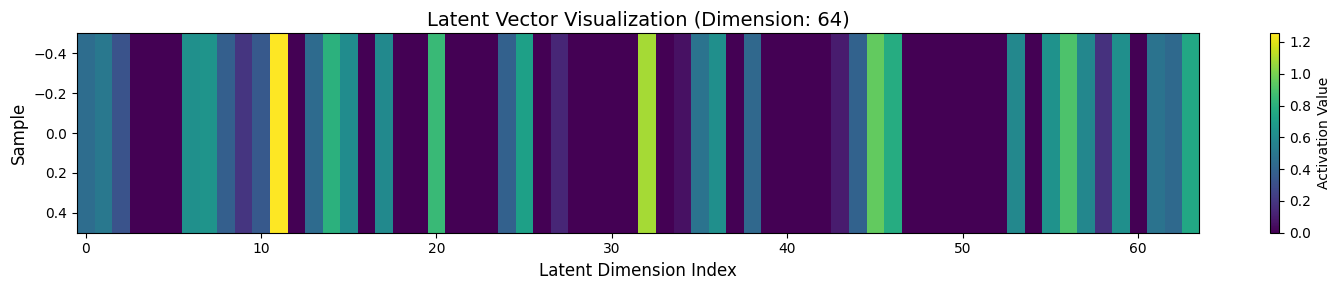

In [ ]:
# %% Cell 16: Visualize latent vector
plt.figure(figsize=(15, 3))
plt.imshow(sample_latent_vectors[0].reshape(1, -1), aspect='auto', cmap='viridis')
plt.colorbar(label='Activation Value')
plt.title(f'Latent Vector Visualization (Dimension: {latent_dim_default})', fontsize=14)
plt.xlabel('Latent Dimension Index', fontsize=12)
plt.ylabel('Sample', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Experiment 3: Effect of Latent Dimension Size

### Larger latent dimensions preserve more information (better reconstruction), while smaller
### dimensions force the model to learn more compressed representations (worse reconstruction
### but better compression).


In [ ]:
# %% Cell 17: Train autoencoders with different latent dimensions
latent_dims_to_test = [64, 16]
models_dict = {}
results_dict = {}

for latent_dim in latent_dims_to_test:
    print(f"\nTraining Autoencoder with Latent Dimension = {latent_dim}")
    ae, enc, dec = build_autoencoder(latent_dim=latent_dim)
    ae.compile(optimizer='adam', loss='mse', metrics=['mse'])
    hist = ae.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  validation_split=VALIDATION_SPLIT, shuffle=True, verbose=0)
    models_dict[latent_dim] = {'autoencoder': ae, 'encoder': enc, 'decoder': dec}
    results_dict[latent_dim] = hist
    print(f"Final Validation Loss: {hist.history['val_loss'][-1]:.6f}, "
          f"Compression: {3072 / latent_dim:.1f}x")


Training Autoencoder with Latent Dimension = 64
Final Validation Loss: 0.003453, Compression: 48.0x

Training Autoencoder with Latent Dimension = 16
Final Validation Loss: 0.006014, Compression: 192.0x


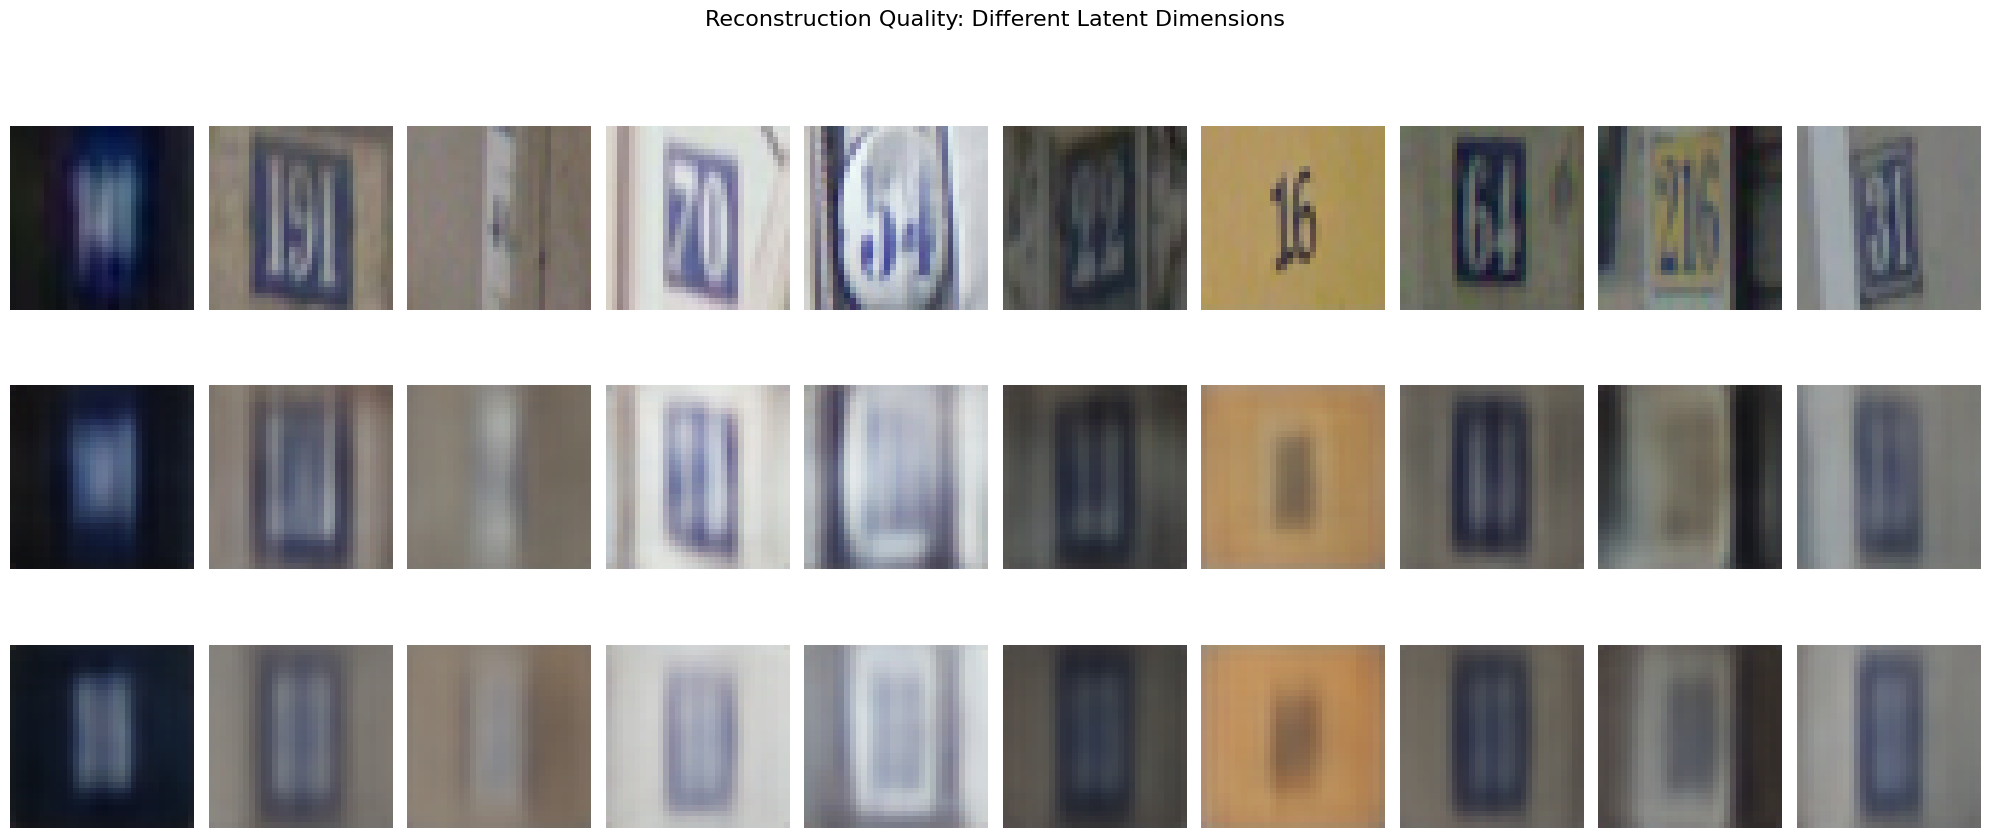

In [ ]:
# %% Cell 18: Compare reconstructions across latent dimensions
fig, axes = plt.subplots(len(latent_dims_to_test) + 1, n_samples,
                         figsize=(20, 3 * (len(latent_dims_to_test) + 1)))

for i in range(n_samples):
    axes[0, i].imshow(sample_images[i])
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12, rotation=0, labelpad=40)

for row_idx, latent_dim in enumerate(latent_dims_to_test, start=1):
    ae = models_dict[latent_dim]['autoencoder']
    reconstructed = ae.predict(sample_images, verbose=0)
    for i in range(n_samples):
        axes[row_idx, i].imshow(reconstructed[i])
        axes[row_idx, i].axis('off')
        if i == 0:
            axes[row_idx, i].set_ylabel(f'Latent={latent_dim}', fontsize=12,
                                       rotation=0, labelpad=40)

plt.suptitle('Reconstruction Quality: Different Latent Dimensions', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# %% Cell 19: Compare latent vectors
print("LATENT VECTOR COMPARISON")
for latent_dim in latent_dims_to_test:
    enc = models_dict[latent_dim]['encoder']
    latent_vectors = enc.predict(sample_images[:1], verbose=0)
    print(f"\nLatent Dim: {latent_dim}, Shape: {latent_vectors[0].shape}, "
          f"Compression: {3072 / latent_dim:.1f}x")
    print(f"First 20 values: {latent_vectors[0][:20]}")
    print(f"Mean: {latent_vectors[0].mean():.4f}, Std: {latent_vectors[0].std():.4f}")


LATENT VECTOR COMPARISON



Latent Dim: 64, Shape: (64,), Compression: 48.0x
First 20 values: [0.5639042  0.         0.7536633  0.401207   0.66203386 0.
 0.16070218 0.50643075 0.63225245 0.46841955 0.5749626  0.742699
 0.         0.8118529  0.13339931 0.6399164  0.43282223 0.39476064
 0.44685417 0.        ]
Mean: 0.3914, Std: 0.3462



Latent Dim: 16, Shape: (16,), Compression: 192.0x
First 20 values: [0.         0.383074   0.22505704 0.6750648  0.75438946 0.
 0.         0.         0.38722306 0.9398288  0.         0.02028955
 0.         0.67848355 0.46880838 0.        ]
Mean: 0.2833, Std: 0.3213


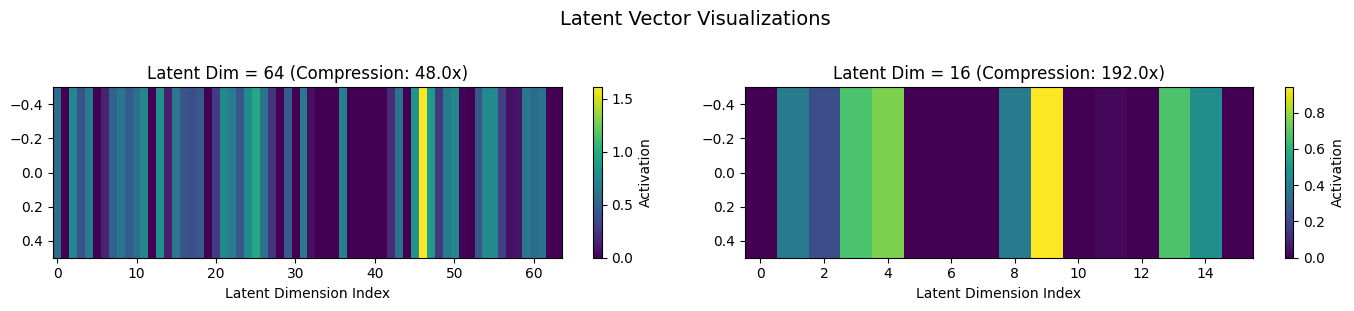

In [ ]:
# %% Cell 20: Visualize latent vectors side by side
fig, axes = plt.subplots(1, len(latent_dims_to_test),
                        figsize=(7 * len(latent_dims_to_test), 3))

for idx, latent_dim in enumerate(latent_dims_to_test):
    enc = models_dict[latent_dim]['encoder']
    latent_vectors = enc.predict(sample_images[:1], verbose=0)
    ax = axes[idx] if len(latent_dims_to_test) > 1 else axes
    im = ax.imshow(latent_vectors[0].reshape(1, -1), aspect='auto', cmap='viridis')
    ax.set_title(f'Latent Dim = {latent_dim} (Compression: {3072/latent_dim:.1f}x)', fontsize=12)
    ax.set_xlabel('Latent Dimension Index', fontsize=10)
    plt.colorbar(im, ax=ax, label='Activation')

plt.suptitle('Latent Vector Visualizations', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# %% Cell 21: Calculate reconstruction errors
print("RECONSTRUCTION ERROR COMPARISON")
for latent_dim in latent_dims_to_test:
    ae = models_dict[latent_dim]['autoencoder']
    reconstructed = ae.predict(sample_images, verbose=0)
    mse = np.mean((sample_images - reconstructed) ** 2)
    print(f"Latent Dim {latent_dim}: MSE = {mse:.6f}, Compression = {3072 / latent_dim:.1f}x")


RECONSTRUCTION ERROR COMPARISON
Latent Dim 64: MSE = 0.003178, Compression = 48.0x
Latent Dim 16: MSE = 0.005792, Compression = 192.0x


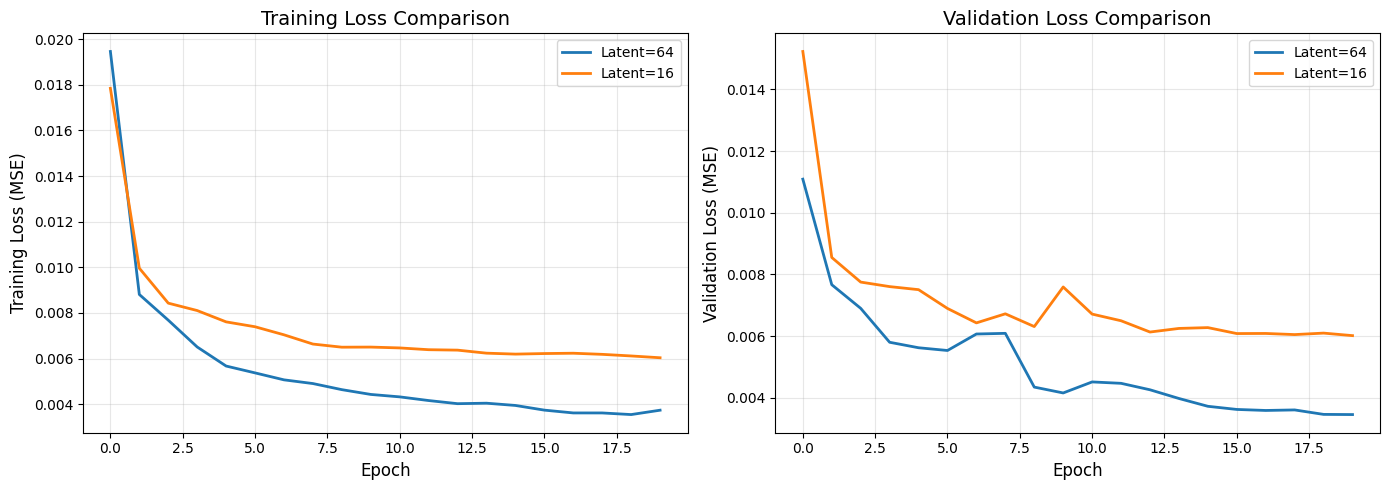

In [ ]:
# %% Cell 22: Plot training curves comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for latent_dim in latent_dims_to_test:
    hist = results_dict[latent_dim]
    plt.plot(hist.history['loss'], label=f'Latent={latent_dim}', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss (MSE)', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for latent_dim in latent_dims_to_test:
    hist = results_dict[latent_dim]
    plt.plot(hist.history['val_loss'], label=f'Latent={latent_dim}', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss (MSE)', fontsize=12)
plt.title('Validation Loss Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Observations:

### Larger latent dimensions (64) preserve more information and produce sharper reconstructions,
### while smaller dimensions (16) achieve higher compression (192x) but may lose fine details.
### Despite high compression, the autoencoder successfully captures essential features needed
### for reconstruction, demonstrating that images contain significant redundancy.

## 8. The Role of Autoencoders in Representation Learning

### **Key Concepts:**

#### 1. **Representation Learning**: Autoencoders automatically learn useful features without supervision
#### 2. **Dimensionality Reduction**: Compresses high-dimensional data while preserving essential information
#### 3. **Unsupervised Learning**: No labels required - learns from data structure itself
#### 4. **Applications**: Denoising, anomaly detection, data generation, feature extraction, compression

## 9. Conclusions

### This notebook successfully demonstrated convolutional autoencoder implementation on SVHN dataset.
#
### **Key Findings:**
#### - Successfully reconstructed RGB images with reasonable fidelity
#### - Achieved 192x compression (latent_dim=16) with recognizable reconstruction
#### - Larger latent dimensions provide better reconstruction with diminishing returns
#### - The autoencoder learns hierarchical features automatically

### **Future Extensions:**
#### - Implement variational autoencoder (VAE)
#### - Add denoising capabilities
#### - Use latent features for digit classification
#### - Explore interpolation in latent space